In [1]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: mps

Support for MPS devices is preliminary. SAM 2 is trained with CUDA and might give numerically different outputs and sometimes degraded performance on MPS. See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion.


In [3]:
import sys
sys.path.append("/Users/huayinluo/Documents/code/zhenlab")

In [5]:
from sam2.build_sam import build_sam2_video_predictor

sam2_checkpoint = "./checkpoints/sam2.1_hiera_tiny.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_t.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

In [4]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

#### Select an example video

In [24]:
import cv2
def create_video_from_folder(folder_path, output_path='output.mp4', fps=30):
    # Get sorted list of .jpg files
    frame_names = sorted([f for f in os.listdir(folder_path) if f.endswith('.jpg')], key=lambda x: int(x.split('.')[0]))
    
    if not frame_names:
        raise ValueError("No .jpg files found in the folder")
    
    # Get frame size from the first image
    first_frame = cv2.imread(os.path.join(folder_path, frame_names[0]))
    height, width, layers = first_frame.shape
    
    # Create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # MP4 codec
    video = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    
    # Write each frame to the video
    for frame_name in frame_names:
        frame = cv2.imread(os.path.join(folder_path, frame_name))
        video.write(frame)
    
    # Release the VideoWriter
    video.release()
    print(f"Video saved as {output_path}")
create_video_from_folder("small_thumbnails_cropped", output_path="small_thumbnails_video.mp4", fps=10)


Video saved as small_thumbnails_video.mp4


(11991, 13769, 3)


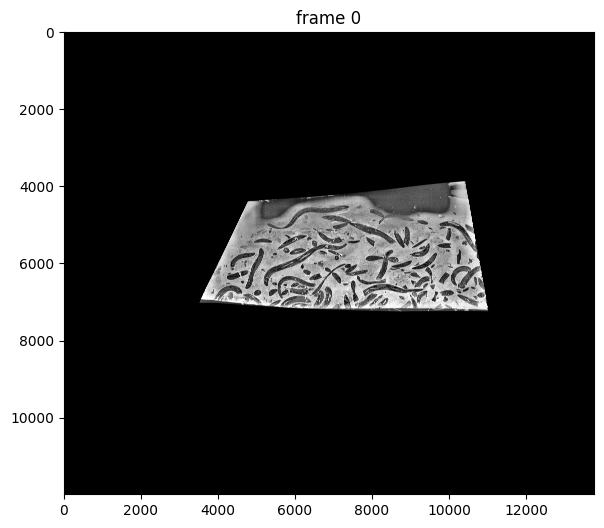

In [5]:
# `video_dir` a directory of PNG frames with filenames like `<frame_index>.png`
import cv2
video_dir = "small_thumbnails"

# scan all the PNG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".png"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0].split('_')[-1]))

# take a look the first video frame
frame_idx = 0
img = cv2.imread(os.path.join(video_dir, frame_names[frame_idx]))
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(img)
print(img.shape)

(3729, 7493, 3)


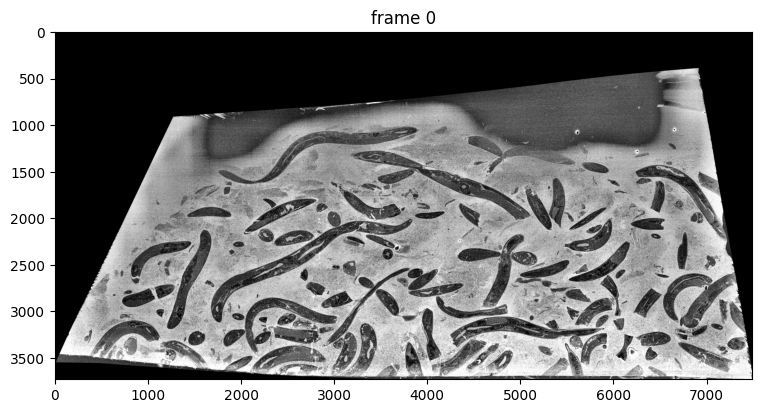

In [17]:
# `video_dir` a directory of PNG frames with filenames like `<frame_index>.png`
import cv2
video_dir = "small_thumbnails_cropped"

# scan all the PNG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0].split('_')[-1]))

# take a look the first video frame
frame_idx = 0
img = cv2.imread(os.path.join(video_dir, frame_names[frame_idx]))
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(img)
print(img.shape)

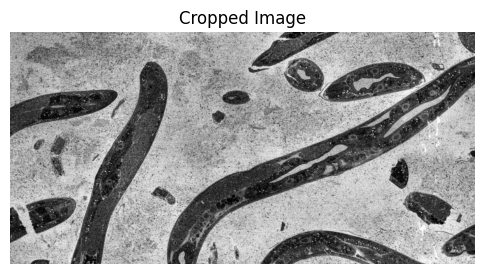

In [35]:
cropped_img = img[2000:3000, 1000:3000]
plt.figure(figsize=(6, 6))
plt.title("Cropped Image")
plt.imshow(cropped_img)
plt.axis('off')
plt.show()

(3729, 7493, 3)
uint8
0 255
Downsampled image shape: (466, 936, 3)
Cropped image shape: (1000, 2000, 3)


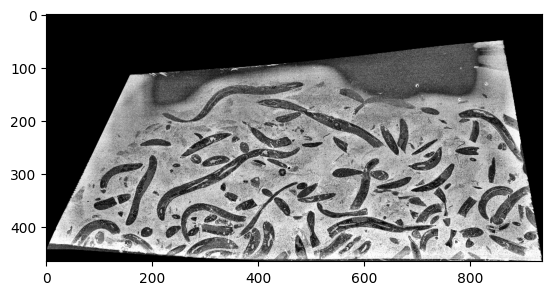

In [67]:

print(img.shape)
print(img.dtype)
print(img.min(), img.max())
# Downsample the image to half its original size
downsample_resolution = 8
downsampled_img = cv2.resize(img, (img.shape[1] // downsample_resolution, img.shape[0] // downsample_resolution))
print("Downsampled image shape:", downsampled_img.shape)
print("Cropped image shape:", cropped_img.shape)

plt.imshow(downsampled_img)

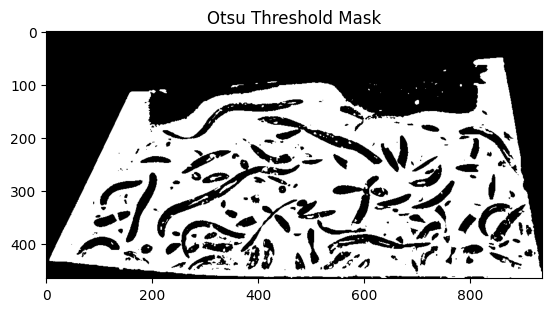

In [ ]:
# Convert to grayscale
gray_img = cv2.cvtColor(downsampled_img, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur to reduce noise
blurred = cv2.GaussianBlur(gray_img, (5, 5), 0)

# Use Otsu's thresholding for better global segmentation
_, initial_mask = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

plt.imshow(initial_mask, cmap='gray')
plt.title('Otsu Threshold Mask')
plt.show()

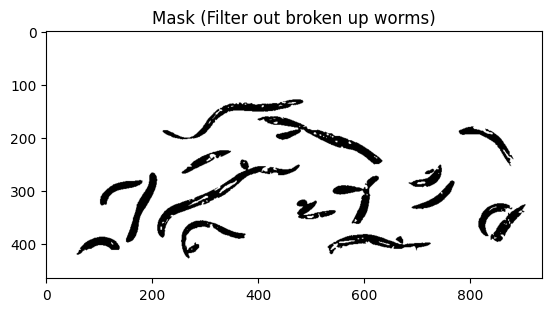

In [120]:
# FILTER FOR RELATIVELY INTACT WORMS (filter out small black blobs)
# Invert the mask to treat black regions as foreground
inv_mask = 255 - initial_mask

# Find connected components in the inverted mask (black blobs)
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(inv_mask, connectivity=8)

# Filter out small black blobs (area too small, e.g., 1000 pixels) 
min_area = 1000
filtered_mask = initial_mask.copy()
for i in range(1, num_labels):  # Skip background (label 0)
    if stats[i, cv2.CC_STAT_AREA] < min_area:
        # Set small black blobs to white (255)
        filtered_mask[labels == i] = 255

# Also filter out black bg (area too large)
max_area = 50000
for i in range(1, num_labels):
    if stats[i, cv2.CC_STAT_AREA] > max_area:
        # Set huge black blobs to white (255)
        filtered_mask[labels == i] = 255

# Display the mask
plt.imshow(filtered_mask, cmap='gray')
plt.title('Mask (Filter out broken up worms)')
plt.show()

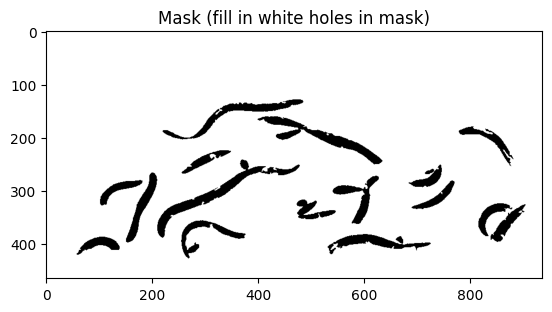

True

In [121]:

# Fill small white holes in the black blobs
filled_mask = filtered_mask.copy()
num_labels_white, labels_white, stats_white, centroids_white = cv2.connectedComponentsWithStats(filled_mask, connectivity=8)
min_hole_area = 100000  # Adjust this threshold as needed for hole size
for i in range(1, num_labels_white):
    if stats_white[i, cv2.CC_STAT_AREA] < min_hole_area:
        filled_mask[labels_white == i] = 0  # Fill small white holes with black

# Display the mask
plt.imshow(filled_mask, cmap='gray')
plt.title('Mask (fill in white holes in mask)')
plt.show()
cv2.imwrite('filled_mask.png', filled_mask)

Blob centers: [(np.int64(349), np.int64(144)), (np.int64(505), np.int64(191)), (np.int64(846), np.int64(202)), (np.int64(303), np.int64(241)), (np.int64(338), np.int64(296)), (np.int64(717), np.int64(268)), (np.int64(178), np.int64(332)), (np.int64(595), np.int64(299)), (np.int64(138), np.int64(293)), (np.int64(736), np.int64(319)), (np.int64(498), np.int64(330)), (np.int64(840), np.int64(337)), (np.int64(872), np.int64(360)), (np.int64(306), np.int64(367)), (np.int64(623), np.int64(395)), (np.int64(92), np.int64(398))]


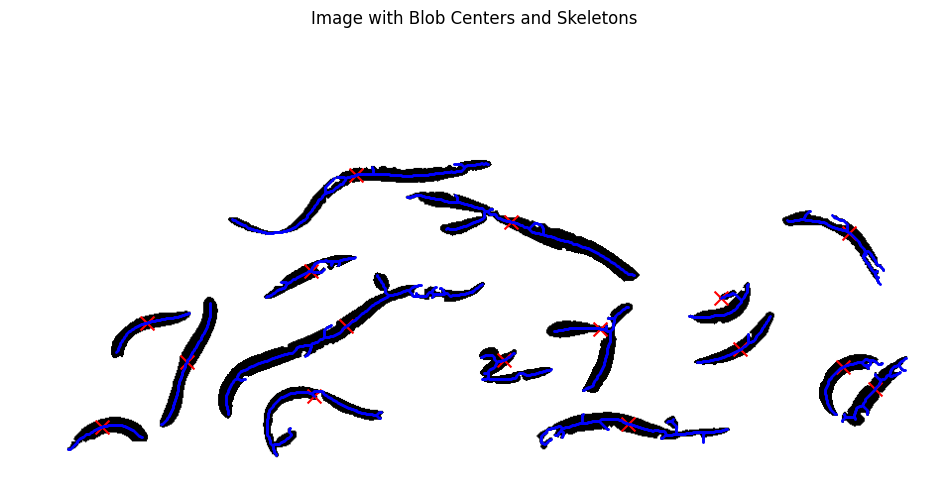

In [123]:
from skimage.morphology import skeletonize

# Find centroids of the black blobs
mask = filled_mask
display_img = mask.copy()
num_labels_blobs, labels_blobs, stats_blobs, centroids_blobs = cv2.connectedComponentsWithStats(255 - mask, connectivity=8)
blob_centers = []
skeleton_points_list = []  # List to store skeleton points for each blob
for i in range(1, num_labels_blobs):
    area = stats_blobs[i, cv2.CC_STAT_AREA]
    if area >= min_area:  # Use the same min_area as before for consistency
        blob_mask = (labels_blobs == i).astype(np.uint8)
        skeleton = skeletonize(blob_mask)
        skeleton_points = np.where(skeleton)
        if len(skeleton_points[0]) > 0:
            # Take the center of mass of the skeleton as the middle point
            cy = int(np.mean(skeleton_points[0]))
            cx = int(np.mean(skeleton_points[1]))
            # Find the skeleton point closest to the center of mass
            distances = np.sqrt((skeleton_points[1] - cx)**2 + (skeleton_points[0] - cy)**2)
            closest_idx = np.argmin(distances)
            cx_actual = skeleton_points[1][closest_idx]
            cy_actual = skeleton_points[0][closest_idx]
            blob_centers.append((cx_actual, cy_actual))
            skeleton_points_list.append(skeleton_points)  # Store skeleton points
print("Blob centers:", blob_centers)

plt.figure(figsize=(12, 6))
plt.imshow(display_img, cmap='gray')  # Use cmap='gray' for proper grayscale display
plt.scatter([cx for cx, cy in blob_centers], [cy for cx, cy in blob_centers], color='red', marker='x', s=100)
# Draw skeletons for each blob
for points in skeleton_points_list:
    plt.scatter(points[1], points[0], s=1, color='blue')
plt.title('Image with Blob Centers and Skeletons')
plt.axis('off')
plt.show()


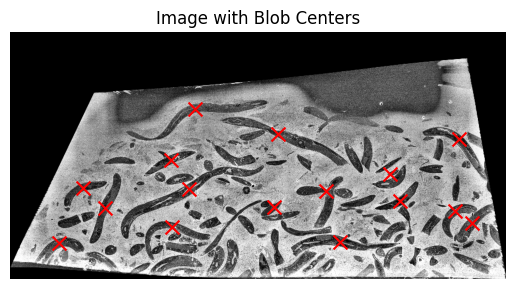

In [124]:
plt.imshow(downsampled_img)
plt.scatter([cx for cx, cy in blob_centers], [cy for cx, cy in blob_centers], color='red', marker='x', s=100)
plt.title('Image with Blob Centers')
plt.axis('off')
plt.show()

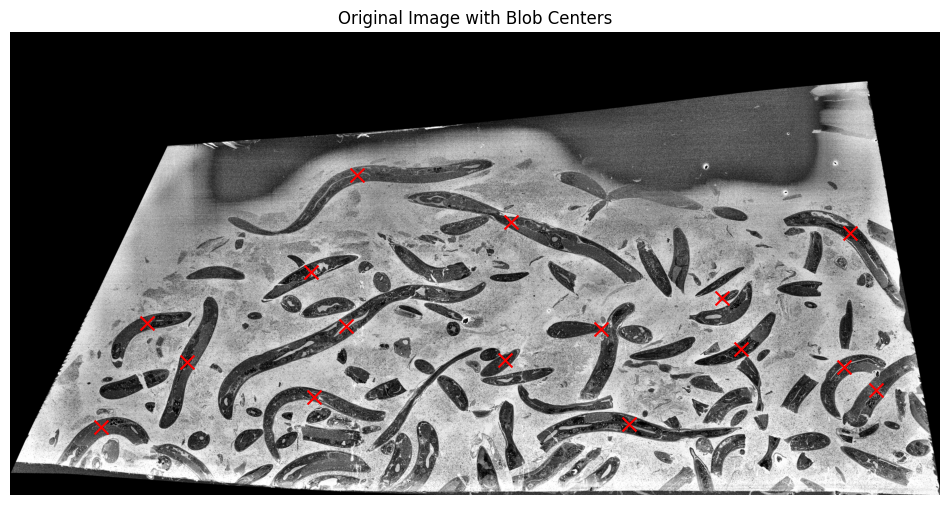

In [125]:
# Scale the blob centers back to the original image coordinates
scaled_blob_centers = [(cx * downsample_resolution, cy * downsample_resolution) for cx, cy in blob_centers]

# Display the original image with scaled blob centers
plt.figure(figsize=(12, 8))
plt.imshow(img)
plt.scatter([cx for cx, cy in scaled_blob_centers], [cy for cx, cy in scaled_blob_centers], color='red', marker='x', s=100)
plt.title('Original Image with Blob Centers')
plt.axis('off')
plt.show()

In [29]:
print(mask.min(), mask.max())
print(np.unique(mask))

0 255
[  0 255]


(3729, 7493, 3)
uint8
0 255
Downsampled image shape: (466, 936, 3)


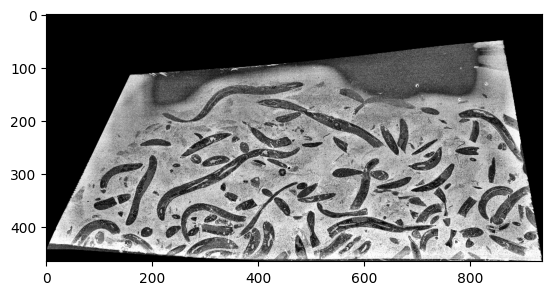

In [21]:
print(img.shape)
print(img.dtype)
print(img.min(), img.max())
# Downsample the image to half its original size
downsample_resolution = 8
downsampled_img = cv2.resize(img, (img.shape[1] // downsample_resolution, img.shape[0] // downsample_resolution))
print("Downsampled image shape:", downsampled_img.shape)

plt.imshow(downsampled_img)

In [23]:
def downsample_and_save(video_dir, save_dir, downsample_resolution=8):
    """Downsample all images in video_dir and save to save_dir."""
    if os.path.exists(save_dir) and not os.path.isdir(save_dir):
        raise NotADirectoryError(f"{save_dir} exists and is not a directory")
    os.makedirs(save_dir, exist_ok=True)

    frame_names = [
        p for p in os.listdir(video_dir)
        if os.path.splitext(p)[-1] in [".jpg", ".png"]
    ]
    frame_names.sort(key=lambda p: int(os.path.splitext(p)[0].split('_')[-1]) if '_' in os.path.splitext(p)[0] else int(os.path.splitext(p)[0]))

    for i, frame_name in enumerate(frame_names):
        img_fp = os.path.join(video_dir, frame_name)
        img = cv2.imread(img_fp)
        downsampled_img = cv2.resize(img, (img.shape[1] // downsample_resolution, img.shape[0] // downsample_resolution))
        save_fp = os.path.join(save_dir, f"{i}.jpg")
        cv2.imwrite(save_fp, downsampled_img)

# Example usage:
downsample_and_save("small_thumbnails_cropped", "small_thumbnails_downsampled", downsample_resolution=8)

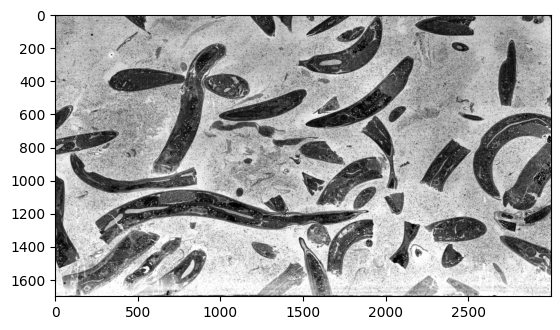

In [8]:
cropped_img = img[2000:3700, 4000:7000, :]
plt.imshow(cropped_img)

In [14]:
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

sam2_checkpoint = "./checkpoints/sam2.1_hiera_tiny.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_t.yaml"

sam2 = build_sam2(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=False)

# mask_generator = SAM2AutomaticMaskGenerator(sam2)
mask_generator = SAM2AutomaticMaskGenerator(
    model=sam2,
    points_per_side=64,
    points_per_batch=128,
    pred_iou_thresh=0.7,
    stability_score_thresh=0.92,
    stability_score_offset=0.7,
    crop_n_layers=1,
    box_nms_thresh=0.7,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=25.0,
    use_m2m=True,
)
masks = mask_generator.generate(cropped_img)

KeyboardInterrupt: 

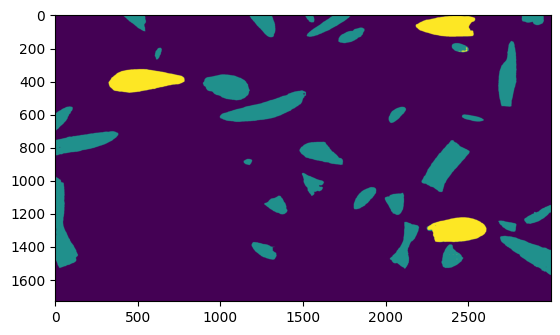

In [ ]:
combined_masks = sum([mask['segmentation'] for mask in masks])
plt.imshow(combined_masks)

In [ ]:
import cv2
import numpy as np
img_fp = os.path.join(video_dir, frame_names[frame_idx])
img = cv2.imread(img_fp)  # BGR
print(img.shape)

(11991, 13769, 3)


In [43]:
from tqdm import tqdm

def get_cropped_pixels(img, thresh=254):
    """
    Crop an image to remove black or near-black borders by finding the bounding box
    of pixels above the threshold in any channel.

    Parameters:
    - img: numpy array (H, W, C) - the input image
    - thresh: int (0-255) - threshold below which pixels are considered "black"

    Returns:
    - x0, y0, x1, y1: coordinates of the cropped bounding box, or None if no content found
    """
    # Create mask for pixels that are not black (above thresh in any channel)
    mask = (img > thresh).any(axis=2)
    if mask.any():
        ys, xs = np.where(mask)
        y0, y1 = ys.min(), ys.max()
        x0, x1 = xs.min(), xs.max()
        return x0, y0, x1, y1
    return None
    

def shrink_video(video_dir, save_dir):
    """Shrink video frames by cropping black borders."""
    if os.path.exists(save_dir) and not os.path.isdir(save_dir):
        raise NotADirectoryError(f"{save_dir} exists and is not a directory")
    os.makedirs(save_dir, exist_ok=True)

    frame_names = [
        p for p in os.listdir(video_dir)
        if os.path.splitext(p)[-1] in [".png"]
    ]
    frame_names.sort(key=lambda p: int(os.path.splitext(p)[0].split('_')[-1]))

    # gets the overall cropping box across all frames
    min_x0, min_y0 = float('inf'), float('inf')
    max_x1, max_y1 = -1, -1
    for frame_name in tqdm(frame_names, desc="Calculating cropping box"):
        img_fp = os.path.join(video_dir, frame_name)
        img = cv2.imread(img_fp)  # BGR
        x0, y0, x1, y1 = get_cropped_pixels(img, thresh=254)
        if x0 is not None:
            min_x0 = min(min_x0, x0)
            min_y0 = min(min_y0, y0)
            max_x1 = max(max_x1, x1)
            max_y1 = max(max_y1, y1)
        # print(f"Frame {frame_name} | x0 {x0} (min {min_x0}) | y0 {y0} (min {min_y0}) | x1 {x1} (max {max_x1}) | y1 {y1} (max {max_y1})", end="\r")
    
    # crop all frames using the overall cropping box
    for i, frame_name in tqdm(enumerate(frame_names), desc="Cropping and saving frames"):
        img_fp = os.path.join(video_dir, frame_name)
        save_fp = os.path.join(save_dir, f"{i}.jpg")
        img = cv2.imread(img_fp)  # BGR
        cropped_img = img[min_y0:max_y1, min_x0:max_x1]
        cv2.imwrite(save_fp, cropped_img)

video_dir = "small_thumbnails"
save_dir = "small_thumbnails_cropped"
shrink_video(video_dir, save_dir)

Calculating cropping box: 100%|██████████| 11/11 [00:28<00:00,  2.56s/it]
Cropping and saving frames: 11it [00:09,  1.18it/s]
Cropping and saving frames: 11it [00:09,  1.18it/s]


In [38]:
for frame_name in frame_names:
    img = cv2.imread(os.path.join("small_thumbnails_cropped", frame_name))
    print(img.shape)

(3224, 7428, 3)
(3718, 7484, 3)
(3718, 7484, 3)
(3515, 7302, 3)
(3515, 7302, 3)
(3588, 7098, 3)
(3588, 7098, 3)
(2178, 7154, 3)
(2178, 7154, 3)
(2609, 7333, 3)
(2609, 7333, 3)
(3380, 7388, 3)
(3380, 7388, 3)
(3481, 7433, 3)
(1999, 6798, 3)
(3481, 7433, 3)
(1999, 6798, 3)
(3461, 7316, 3)
(1995, 6544, 3)
(3461, 7316, 3)
(1995, 6544, 3)


#### Initialize the inference state

SAM 2 requires stateful inference for interactive video segmentation, so we need to initialize an **inference state** on this video.

During initialization, it loads all the JPEG frames in `video_path` and stores their pixels in `inference_state` (as shown in the progress bar below).

In [44]:
video_dir = "small_thumbnails_cropped"
inference_state = predictor.init_state(video_path=video_dir)

frame loading (JPEG): 100%|██████████| 11/11 [00:03<00:00,  3.62it/s]



### Example 1: Segment & track one object

Note: if you have run any previous tracking using this `inference_state`, please reset it first via `reset_state`.

(The cell below is just for illustration; it's not needed to call `reset_state` here as this `inference_state` is just freshly initialized above.)

In [45]:
predictor.reset_state(inference_state)

#### Step 1: Add a first click on a frame

In [47]:
# `video_dir` a directory of PNG frames with filenames like `<frame_index>.png`
video_dir = "small_thumbnails_cropped"

# scan all the PNG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0].split('_')[-1]))

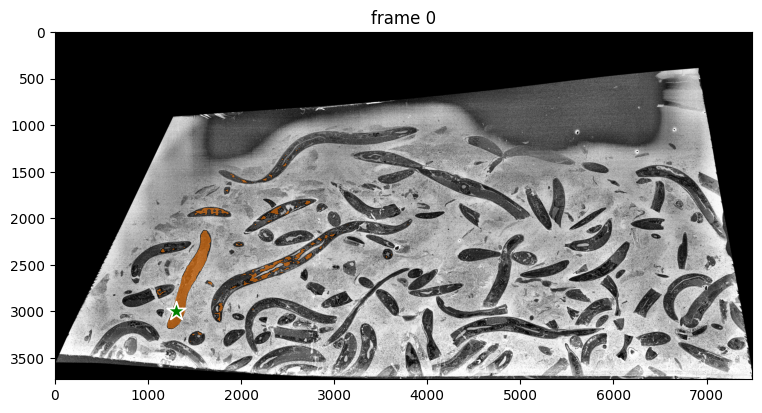

In [51]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

# Let's add a positive click at (x, y) = (210, 350) to get started
points = np.array([[1300, 3000]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1], np.int32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

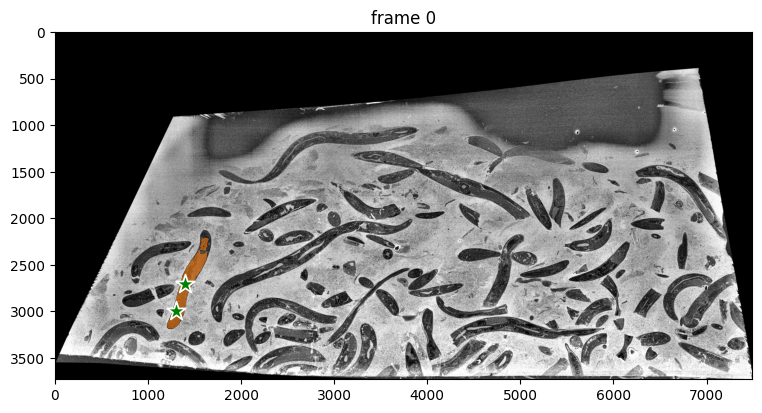

In [53]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

# Let's add a 2nd positive click at (x, y) = (250, 220) to refine the mask
# sending all clicks (and their labels) to `add_new_points_or_box`
points = np.array([[1300, 3000], [1400, 2700]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1, 1], np.int32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

With this 2nd refinement click, now we get a segmentation mask of the entire child on frame 0.

In [78]:
# run propagation throughout the video and collect the results in a dict
results_dir = f"{video_dir}_masks"
os.makedirs(results_dir, exist_ok=True)
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    mask = (out_mask_logits[0] > 0.0).cpu().numpy()
    # video_segments[out_frame_idx] = {
    #     out_obj_id: mask
    #     for i, out_obj_id in enumerate(out_obj_ids)
    # }
    save_path = os.path.join(results_dir, f"{out_frame_idx}.jpg")
    mask_uint8 = (mask * 255).astype(np.uint8)
    cv2.imwrite(save_path, mask_uint8[0])

# render the segmentation results every few frames
# vis_frame_stride = 30
# plt.close("all")
# for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
#     plt.figure(figsize=(6, 4))
#     plt.title(f"frame {out_frame_idx}")
#     plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
#     for out_obj_id, out_mask in video_segments[out_frame_idx].items():
#         show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

1it [00:00,  1.27it/s]/Users/huayinluo/Documents/code/zhenlab/zhenvenv/lib/python3.13/site-packages/sam2/sam2_video_predictor.py:786: UserWarning: cannot import name '_C' from 'sam2' (/Users/huayinluo/Documents/code/zhenlab/zhenvenv/lib/python3.13/site-packages/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(
/Users/huayinluo/Documents/code/zhenlab/zhenvenv/lib/python3.13/site-packages/sam2/sam2_video_predictor.py:786: UserWarning: cannot import name '_C' from 'sam2' (/Users/huayinluo/Documents/code/zhenlab/zhenvenv/lib/python3.13/site-packages/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error abo

In [25]:
def create_video_from_frames(video_dir, frame_names, video_path=None, fps=30):
    if video_path is None:
        video_path = f"{video_dir}.mp4"
    
    # Get frame size from the first image
    first_frame = cv2.imread(os.path.join(video_dir, frame_names[0]))
    height, width, layers = first_frame.shape
    
    # Create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # MP4 codec
    video = cv2.VideoWriter(video_path, fourcc, fps, (width, height))
    
    # Write each frame to the video
    for frame_name in frame_names:
        frame = cv2.imread(os.path.join(video_dir, frame_name))
        video.write(frame)
    
    # Release the VideoWriter
    video.release()
    print(f"Video saved as {video_path}")

# Example usage:
create_video_from_frames("small_thumbnails_cropped_masks", frame_names, fps=5)

Video saved as small_thumbnails_cropped_masks.mp4
